In [4]:
!pip install geopandas libpysal esda spreg shapely pyproj pandas numpy matplotlib statsmodels

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB 660.6 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.8 MB 1.1 MB/s eta 0:00:03
   -- ------------------------------------- 0.2/2.8 MB 1.5 MB/s eta 0:00:02
   ---- ----------------------------------- 0.3/2.8 MB 1.8 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.8 MB 2.2 MB/s eta 0:00:02
   ---------- ----------------------------- 0.7/2.8 MB 2.7 MB/s eta 0:00:01
   ------------- -------------------------- 1.0/2.8 MB 3.1 MB/s eta 0:00:01
   ----------------- ---------------------- 1.2/2.8 MB 3.3 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.8 MB 3.3 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 3.5 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 3.5 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.8 MB 3.6 MB/s eta 0:00:01
   --------------

Reading data...
Records merged: 314
Building spatial weights...


C:\Users\DELL\AppData\Local\Temp\ipykernel_1840\4092534225.py:72: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
D:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 3 islands with ids: 43, 49, 292.
  W.__init__(self, neighbors, ids=ids, **kw)


Islands found: [43, 49, 292] — filling with 1-nearest neighbors.


D:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 74 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
D:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\set_operations.py:80: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  return W(neighbors, **kwargs)


Running OLS + diagnostics...
Fitting SAR and SEM...


D:\Users\DELL\anaconda3\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


        name      beta            se
0      const  8.587737  6.933763e+00
1  built_sum -0.000002  6.312999e-07
2    pop_sum  0.000607  4.704586e-05 

        name          beta            se
0      const -2.429022e+01  6.789681e+00
1  built_sum -9.455172e-07  5.631058e-07
2    pop_sum  4.781089e-04  4.425788e-05
3        rho  4.449995e-01           NaN 

        name          beta            se
0      const  6.117076e+00  1.078491e+01
1  built_sum -9.427968e-07  6.203009e-07
2    pop_sum  5.402325e-04  4.759846e-05
3     lambda  7.102725e-01           NaN
Done. Results saved to: D:/ERP/Data/output/outputs
Use ML_Error coefficients for dasymetric weighting.


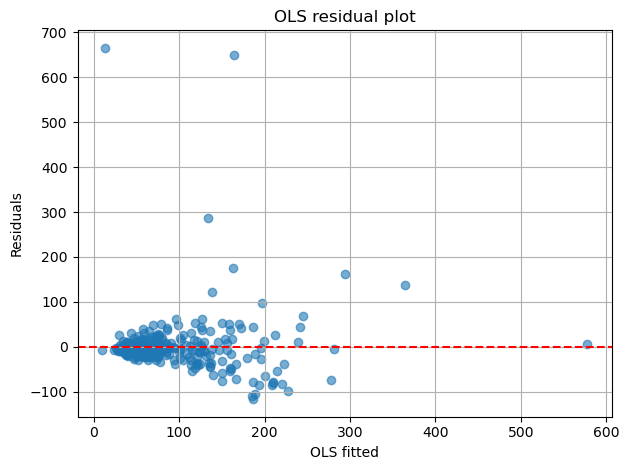

In [8]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# —— Setting Parameters ————————————————————————————————
USE_LOG = False   # if True apply ln(x+1) to employment/built/pop
COUNTRY_PREFIX = ("E","W")  # keep only England/Wales LAD

# Path
PATH_LAD_SHP = r"D:/ERP/Data/Local_Authority_Districts_(May_2025)_Boundaries_UK_BFC_(V2)/Local_Authority_Districts_(May_2025)_Boundaries_UK_BFC_(V2).shp"
PATH_EMP     = r"D:/ERP/Data/Employment_LA.csv"                  # column: Local Authority District, Total employment (all)
PATH_BUILT   = r"D:/ERP/Data/GHSL_sumtile/built_sum_TableToExcel.csv"         # column: LAD25CD, SUM
PATH_POP     = r"D:/ERP/Data/GHSL_sumtile/pop_sum.csv"                        # column: LAD25CD, SUM
OUT_DIR      = r"D:/ERP/Data/output/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ———— 1. Read/Combine data ————————————————————————
print("Reading data...")
lad = gpd.read_file(PATH_LAD_SHP)
lad = lad[lad["LAD25CD"].str.startswith(COUNTRY_PREFIX)].reset_index(drop=True)
lad = lad[["LAD25CD","LAD25NM","geometry"]]

emp = pd.read_csv(PATH_EMP)
emp = emp.rename(columns={"Local Authority District":"LAD25NM",
                          "Total employment (all)":"employment_total_k"})
emp["employment_total_k"] = pd.to_numeric(emp["employment_total_k"], errors="coerce")

built = pd.read_csv(PATH_BUILT)
built = built.rename(columns={"SUM":"built_sum"})[["LAD25CD","built_sum"]]

pop = pd.read_csv(PATH_POP)
pop = pop.rename(columns={"SUM":"pop_sum"})[["LAD25CD","pop_sum"]]

# Combine code→name to built/pop，then combine with employment data according to names
lad_attr = lad.drop(columns="geometry")
built_named = built.merge(lad_attr, on="LAD25CD", how="left")
pop_named   = pop.merge(lad_attr, on="LAD25CD", how="left")

df = (lad_attr
      .merge(built_named[["LAD25CD","built_sum"]], on="LAD25CD", how="left")
      .merge(pop_named[["LAD25CD","pop_sum"]], on="LAD25CD", how="left")
      .merge(emp[["LAD25NM","employment_total_k"]], on="LAD25NM", how="inner"))

gdf = lad.merge(df, on=["LAD25CD","LAD25NM"], how="inner")
print(f"Records merged: {len(gdf)}")

# copy original data
gdf["emp_orig"]   = gdf["employment_total_k"].copy()
gdf["built_orig"] = gdf["built_sum"].copy()
gdf["pop_orig"]   = gdf["pop_sum"].copy()

if USE_LOG:
    for col, new in [("employment_total_k","ln_emp"),
                     ("built_sum","ln_built"),
                     ("pop_sum","ln_pop")]:
        gdf[new] = np.log1p(gdf[col].clip(lower=0))  # ln(x+1)
    y_col = "ln_emp"; X_cols = ["ln_built","ln_pop"]
else:
    y_col = "employment_total_k"; X_cols = ["built_sum","pop_sum"]

# drop missing value
gdf = gdf.dropna(subset=[y_col]+X_cols).reset_index(drop=True)

# ———— 2. Build spatial weights (Queen contiguity, row-standardized, with kNN=1 for isolated areas) ————————————
print("Building spatial weights...")
import libpysal as lps
from libpysal.weights import Queen, KNN

w = Queen.from_dataframe(gdf)
if w.islands:
    # If there are islands (no neighbors), fill using 1-nearest neighbor (kNN).
    print(f"Islands found: {w.islands} — filling with 1-nearest neighbors.")
    w_knn = KNN.from_dataframe(gdf, k=1)
    w = lps.weights.w_union(w, w_knn)
w.transform = "R"  

# ———— 3. OLS Regression + Residual Moran’s I + LM test ————————————————
print("Running OLS + diagnostics...")
from spreg import OLS
from esda.moran import Moran

y = gdf[[y_col]].values
X = gdf[X_cols].values
ols = OLS(y, X, w=w, spat_diag=True, name_y=y_col, name_x=X_cols)
ols_resid = ols.u  # residual
mi = Moran(ols_resid, w)

# ———— 4. SAR & SEM ——————————————————————————————
print("Fitting SAR and SEM...")
from spreg import ML_Lag, ML_Error

sar = ML_Lag(y, X, w=w, name_y=y_col, name_x=X_cols)
sem = ML_Error(y, X, w=w, name_y=y_col, name_x=X_cols)

# ———— 5. Model comparison & output ——————————————————————————
def grab_summary(m):
    return {
        "model":    type(m).__name__,
        "n":        m.n,
        "k":        m.k,
        "loglik":   getattr(m, "llf", np.nan),
        "aic":      getattr(m, "aic", np.nan),
        "r2":       getattr(m, "pr2", np.nan),  # pseudo R^2
    }

cmp = pd.DataFrame([grab_summary(ols), grab_summary(sar), grab_summary(sem)])
cmp.to_csv(os.path.join(OUT_DIR, "model_compare.csv"), index=False)

# Coefficient table
def coef_table(m, X_cols):
    names = ["const"] + X_cols
    beta = np.ravel(m.betas)[:len(names)]

    if hasattr(m, "std_err") and m.std_err is not None:
        se = np.ravel(m.std_err)[:len(names)]
    else:
        V = getattr(m, "varb", getattr(m, "vm", None))
        se = np.sqrt(np.diag(V))[:len(names)] if V is not None else [np.nan]*len(names)

    out = pd.DataFrame({"name": names, "beta": beta, "se": se})

    # Spatial parameters
    if hasattr(m, "rho"):
        out.loc[len(out)] = ["rho", m.rho, np.nan]
    if hasattr(m, "lam"):
        out.loc[len(out)] = ["lambda", m.lam, np.nan]
    return out
    

# Assuming that y_col, X_cols, y, X, w, and the ols/sar/sem models have already been fitted

# 1) Coefficient table and export
coef_ols = coef_table(ols, X_cols)
coef_sar = coef_table(sar, X_cols)
coef_sem = coef_table(sem, X_cols)

coef_ols.to_csv("D:/ERP/Data/output/outputs/coef_ols.csv", index=False)
coef_sar.to_csv("D:/ERP/Data/output/outputs/coef_sar.csv", index=False)
coef_sem.to_csv("D:/ERP/Data/output/outputs/coef_sem.csv", index=False)

# 2) Quick check
print(coef_ols.head(), "\n")
print(coef_sar.head(), "\n")
print(coef_sem.head())

# Moran's I on OLS residuals
with open(os.path.join(OUT_DIR,"diagnostics.txt"), "w", encoding="utf-8") as f:
    f.write(ols.summary)  # 含 LM-lag / LM-error 及 Robust 版本
    f.write("\n\nMoran's I on OLS residuals:\n")
    f.write(f"I={mi.I:.4f}, p_sim={mi.p_sim:.4g}\n")

# Residual plot
plt.figure()
plt.scatter(ols.predy.flatten(), ols_resid.flatten(), alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("OLS fitted")
plt.ylabel("Residuals")
plt.title("OLS residual plot")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"ols_residual_plot.png"), dpi=160)

print("Done. Results saved to:", OUT_DIR)

# ———— 6. Generate 1km downscaled weights using spatial regression coefficients ————————————
best = min([sar, sem], key=lambda m: getattr(m, "aic", np.inf))
best_name = type(best).__name__
print(f"Use {best_name} coefficients for dasymetric weighting.")

if USE_LOG:
    note = (
        "Log model chosen. For each 1km cell i within an LAD:\n"
        "  w_i = exp(beta0 + beta1*ln(B_i+1) + beta2*ln(P_i+1))\n"
        "  E_i = w_i / sum_j(w_j in LAD) * Employment_LAD\n"
        "Clip negatives not needed (exp>=0)."
    )
else:
    note = (
        "Linear model chosen. For each 1km cell i within an LAD:\n"
        "  w_i = max( beta0 + beta1*B_i + beta2*P_i , 0 )\n"
        "  E_i = w_i / sum_j(w_j in LAD) * Employment_LAD\n"
        "If many zeros, rescale B_i and P_i (z-score) or min-max before applying."
    )
with open(os.path.join(OUT_DIR,"grid_weighting_readme.txt"), "w") as f:
    f.write(note)


In [9]:
!pip install geopandas rasterio pyproj pandas numpy shapely

In [18]:
# -*- coding: utf-8 -*-
"""
A-scheme (LOG Model + Exponential Weights; using the built_sum/pop_sum CSV)
Steps:
1) Read LAD boundaries + Employment (by LAD name);
2) Merge LAD-level built_sum/pop_sum using CSV (by LAD25CD);
3) Construct ln variables, perform OLS → SAR/SEM (select the best model using AIC), only take the "slope" coefficients;
4) Open GHSL BUILT/POP raster, crop by LAD → clean → calculate exponential weights;
5) Normalize and allocate employment within each LAD, write back to the overall 1km raster;
6) Export GeoTIFF and WGS84 point CSV, and perform total verification.
"""

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from rasterio.transform import rowcol
from shapely.geometry import mapping
from pyproj import Transformer

PATH_LAD_SHP = r"D:/ERP/Data/Local_Authority_Districts_(May_2025)_Boundaries_UK_BFC_(V2)/Local_Authority_Districts_(May_2025)_Boundaries_UK_BFC_(V2).shp"
PATH_EMP     = r"D:/ERP/Data/Employment_LA.csv"                  # column: Local Authority District, Total employment (all)
PATH_BUILT_CSV = r"D:/ERP/Data/GHSL_sumtile/built_sum_TableToExcel.csv"       # column: LAD25CD, SUM
PATH_POP_CSV   = r"D:/ERP/Data/GHSL_sumtile/pop_sum.csv"                      # column: LAD25CD, SUM
PATH_BUILT_TIF   = r"D:/ERP/Data/GHSL ALL/GHS_BUILT_merged.tif"         # GHSL 1km, EPSG:54009
PATH_POP_TIF     = r"D:/ERP/Data/GHSL POP/GHS_POP_merged.tif"           # GHSL 1km, EPSG:54009

OUT_DIR      = r"D:/ERP/Data/output/outputs_log_from_csv"
OUT_TIF      = r"D:/ERP/Data/output/employment_1km_SEM.tif"
OUT_CSV_WGS  = r"D:/ERP/Data/output/employment_1km_SEM_points_wgs84.csv"
OUT_COEF_CSV = os.path.join(OUT_DIR, "best_model_slopes.csv")
OUT_CMP_CSV  = os.path.join(OUT_DIR, "model_compare.csv")

KEEP_PREFIX  = ("E","W")     # keep only England/Wales
EMP_IN_THOUSANDS = True      

os.makedirs(OUT_DIR, exist_ok=True)

# ========= 1) Read LAD + Employment =========
lad = gpd.read_file(PATH_LAD_SHP)
lad = lad[lad["LAD25CD"].str.startswith(KEEP_PREFIX)].reset_index(drop=True)
lad = lad[["LAD25CD","LAD25NM","geometry"]]

emp = pd.read_csv(PATH_EMP)
emp = emp.rename(columns={
    "Local Authority District": "LAD25NM",
    "Total employment (all)": "employment_total_k"
})
emp["employment_total_k"] = pd.to_numeric(emp["employment_total_k"], errors="coerce")

lad = lad.merge(emp[["LAD25NM","employment_total_k"]], on="LAD25NM", how="left")
miss = lad["employment_total_k"].isna().sum()
if miss > 0:
    print(f"[Warn] {miss} LADs missing employment; please check LAD names.")
lad = lad.dropna(subset=["employment_total_k"]).reset_index(drop=True)

# ========= 2) Merge built_sum / pop_sum using CSV (by LAD25CD) =========
built = pd.read_csv(PATH_BUILT_CSV).rename(columns={"SUM":"built_sum"})
pop   = pd.read_csv(PATH_POP_CSV).rename(columns={"SUM":"pop_sum"})

lad = lad.merge(built[["LAD25CD","built_sum"]], on="LAD25CD", how="left") \
         .merge(pop[["LAD25CD","pop_sum"]],   on="LAD25CD", how="left")

miss2 = lad[["built_sum","pop_sum"]].isna().sum()
if miss2.any():
    print(f"[Warn] missing built/pop after merge: {dict(miss2)}")
lad = lad.dropna(subset=["built_sum","pop_sum"]).reset_index(drop=True)

# ========= 3) Logarithmic variables + spatial regression（OLS→SAR/SEM）=========
lad["ln_emp"]   = np.log1p(lad["employment_total_k"])
lad["ln_built"] = np.log1p(lad["built_sum"])
lad["ln_pop"]   = np.log1p(lad["pop_sum"])

import libpysal as lps
from libpysal.weights import Queen, KNN
from esda.moran import Moran
from spreg import OLS, ML_Lag, ML_Error

# Construct weights (Queen, row-standardized; use KNN=1 for islands as fallback)
w = Queen.from_dataframe(lad)
if w.islands:
    print(f"[Info] Islands: {w.islands} → union with 1-NN.")
    w = lps.weights.w_union(w, KNN.from_dataframe(lad, k=1))
w.transform = "R"

y_col  = "ln_emp"
X_cols = ["ln_built","ln_pop"]
y = lad[[y_col]].values
X = lad[X_cols].values

# OLS + diagnostics
ols = OLS(y, X, w=w, spat_diag=True, name_y=y_col, name_x=X_cols)
mi  = Moran(ols.u, w)
print(f"[Diag] Moran's I on OLS residuals: I={mi.I:.4f}, p={mi.p_sim:.4g}")

# SAR / SEM
sar = ML_Lag(y, X, w=w, name_y=y_col, name_x=X_cols)
sem = ML_Error(y, X, w=w, name_y=y_col, name_x=X_cols)

def model_info(mdl, name):
    return {
        "model": name,
        "aic": getattr(mdl,"aic", np.nan),
        "loglik": getattr(mdl,"llf", np.nan),
        "pseudo_r2": getattr(mdl,"pr2", np.nan),
    }

cmp = pd.DataFrame([
    model_info(ols, "OLS"),
    model_info(sar, "SAR"),
    model_info(sem, "SEM")
]).sort_values("aic")
cmp.to_csv(OUT_CMP_CSV, index=False)
best = sem if cmp.iloc[0]["model"]=="SEM" else (sar if cmp.iloc[0]["model"]=="SAR" else ols)
best_name = cmp.iloc[0]["model"]
print(f"[Select] Best by AIC: {best_name}")

# Only take the "slope" coefficients (excluding the intercept) to calculate pixel weights
B1 = float(best.betas[1,0])   # coefficient for ln_built
B2 = float(best.betas[2,0])   # coefficient for ln_pop
pd.DataFrame({"name":["beta_ln_built","beta_ln_pop"], "value":[B1,B2]}).to_csv(OUT_COEF_CSV, index=False)
print(f"[Coef] slopes: beta_ln_built={B1:.6g}, beta_ln_pop={B2:.6g}")

# ========= 4) Read GHSL raster and downscale =========
src_built = rasterio.open(PATH_BUILT_TIF)
src_pop   = rasterio.open(PATH_POP_TIF)
if src_built.crs != src_pop.crs:
    raise RuntimeError("BUILT & POP CRS mismatch.")

# Reproject to GHSL (Mollweide)
lad = lad.to_crs(src_built.crs)

meta = src_built.meta.copy()
meta.update(dtype="float32", count=1, nodata=0.0)
out_arr = np.zeros((meta["height"], meta["width"]), dtype="float32")

total_emp_target = lad["employment_total_k"].sum() * (1000.0 if EMP_IN_THOUSANDS else 1.0)

for _, r in lad.iterrows():
    geom = [mapping(r.geometry)]
    b_clip, bt = mask(src_built, geom, crop=True, filled=True)
    p_clip, _  = mask(src_pop,   geom, crop=True, filled=True)
    b = b_clip[0].astype("float64")
    p = p_clip[0].astype("float64")

    # —— Clean: Set NaN/±inf/negative values to 0 —— #
    b[~np.isfinite(b)] = 0.0
    p[~np.isfinite(p)] = 0.0
    b[b < 0] = 0.0
    p[p < 0] = 0.0

    # Valid pixels: At least one > 0
    valid = (b > 0) | (p > 0)
    if not np.any(valid):
        continue

    # Exponential weights (using only the slope terms; apply log1p only to valid pixels).
    w_cell = np.zeros_like(b, dtype="float64")
    w_cell[valid] = np.exp(B1*np.log1p(b[valid]) + B2*np.log1p(p[valid]))
    # Set non-finite weights to zero
    w_cell[~np.isfinite(w_cell)] = 0.0

    w_sum = float(w_cell.sum())
    emp_total = r["employment_total_k"] * (1000.0 if EMP_IN_THOUSANDS else 1.0)

    if (not np.isfinite(w_sum)) or (w_sum <= 0):
        # Distribute evenly to valid pixels.
        cnt = int(np.count_nonzero(valid))
        if cnt == 0:
            continue
        emp_clip = np.zeros_like(w_cell)
        emp_clip[valid] = emp_total / cnt
    else:
        emp_clip = (w_cell / w_sum) * emp_total

    # Prevent writing back NaN/inf.
    emp_clip[~np.isfinite(emp_clip)] = 0.0

    # —— Robust window write-back: from\_bounds + boundary clipping —— #
    left, bottom, right, top = r.geometry.bounds
    win = from_bounds(left, bottom, right, top, transform=meta["transform"])
    r0 = max(0, win.row_off); c0 = max(0, win.col_off)
    r1 = min(meta["height"], r0 + win.height)
    c1 = min(meta["width"],  c0 + win.width)

    h, wcols = emp_clip.shape
    H = int(r1 - r0); W = int(c1 - c0)
    hh = min(h, H); ww = min(wcols, W)
    if hh > 0 and ww > 0:
        out_arr[int(r0):int(r0)+hh, int(c0):int(c0)+ww] += emp_clip[:hh, :ww].astype("float32")

# ========= 5) Export GeoTIFF + WGS84 point CSV + verification =========
os.makedirs(OUT_DIR, exist_ok=True)
with rasterio.open(OUT_TIF, "w", **meta) as dst:
    dst.write(out_arr, 1)

rows, cols = np.nonzero(out_arr > 0)
xs = meta["transform"].c + (cols + 0.5) * meta["transform"].a
ys = meta["transform"].f + (rows + 0.5) * meta["transform"].e
transformer = Transformer.from_crs(src_built.crs, "EPSG:4326", always_xy=True)
lons, lats = transformer.transform(xs, ys)

pd.DataFrame({
    "lon": lons, "lat": lats, "employment": out_arr[rows, cols].astype("float64")
}).to_csv(OUT_CSV_WGS, index=False)

print("\n== Total verification ==")
print("LAD target total employment: ", f"{total_emp_target:,.0f}")
print("Raster sum of employment: ", f"{out_arr.sum():,.0f}")
print("Difference (Raster - Target): ", f"{(out_arr.sum()-total_emp_target):,.0f}")
print("Number of positive pixels (>0): ", np.count_nonzero(out_arr > 0))
print("\n[Done]")
print("GeoTIFF:", OUT_TIF)
print("CSV:", OUT_CSV_WGS)
print("Model compare:", OUT_CMP_CSV)
print("Chosen slopes:", OUT_COEF_CSV)


[Warn] 4 LADs missing employment; please check LAD names.


C:\Users\DELL\AppData\Local\Temp\ipykernel_1840\3918451243.py:84: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(lad)
D:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 3 islands with ids: 43, 49, 292.
  W.__init__(self, neighbors, ids=ids, **kw)


[Info] Islands: [43, 49, 292] → union with 1-NN.


D:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 74 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
D:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\set_operations.py:80: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  return W(neighbors, **kwargs)


[Diag] Moran's I on OLS residuals: I=0.2858, p=0.001


D:\Users\DELL\anaconda3\Lib\site-packages\spreg\ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


[Select] Best by AIC: SEM
[Coef] slopes: beta_ln_built=-0.0970039, beta_ln_pop=0.93901

== 总量校验 ==
LAD 目标总就业： 28,496,900
栅格求和就业：   26,824,356
差值（栅格-目标）： -1,672,544
正值像元数量（>0）： 159662

[Done]
GeoTIFF: D:/ERP/Data/output/employment_1km_SEM.tif
CSV: D:/ERP/Data/output/employment_1km_SEM_points_wgs84.csv
Model compare: D:/ERP/Data/output/outputs_log_from_csv\model_compare.csv
Chosen slopes: D:/ERP/Data/output/outputs_log_from_csv\best_model_slopes.csv
